# Optimized Model
This model does not show under- or overfitting and performs well on both, training and testing data. Afterwards, a brief description on how to tackle the challenges of an optimal model complexity. 

To address underfitting, one approach is to increase the complexity of the model by adding more layers or increasing the number of filters in each layer. To address overfitting, we can try several approaches. One approach is to simplify the model by removing some layers or decreasing the number of filters in each layer. Another approach is to use less epochs for example.




Adding dropout or weight decay can help to address both of the above mentioned issues. We can also try adjusting the hyperparameters such as learning rate, batch size, or number of epochs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

img_size = 150
batch_size = 64
seed = 31

train_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    './dataset/seg_test/seg_test',
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2666 files belonging to 5 classes.
Using 2133 files for training.


2023-03-07 09:01:23.731564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2666 files belonging to 5 classes.
Using 533 files for validation.
Found 2499 files belonging to 5 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom, Rescaling, RandomFlip

data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

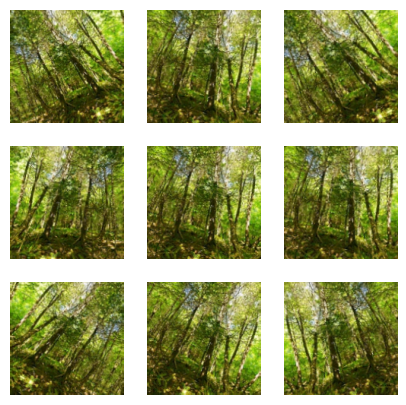

In [4]:
plt.figure(figsize=(5, 5))
for image, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Building the Model
Here we use the same model as the overfitting one but we add some extras to reduce the overfitting behavior.

### Regularization
Regularization is used to reduce the impact impact of the weights. The weights then end up having less impact on the loss function which determines the error between the actual label and predicted label. This reduces complexity of the model and therefore reduces overfitting. We are adding regularization only to those layers which have the largest number of parameters according to the model summary. We are using L2 (Ridge) regularization since it predetermined from the task. We are adding L2 mainly to the layers that add the most parameters to the CNN.

Dropout Layers: The benefit of using dropout is no node in the network will be assigned with high parameter values, as a a result the parameter values will be dispersed and the output of the current layer will not depend on a single node.
E.g. Dropout(0.2) drops the input layers at a probability of 0.2.

### Generalization
To improve generalization of the model, data augmentation is a useful tool. With data augmentation we can add artificial effects to the images such as shearing, stretching, flipping, rotating and translating. Through these effects, the images always appear differently each time they appear in the training step and therefore the CNN doesn't adapt to the exact images but rather learns about the relative features inside of an image.

### Optimizer
For the optimized model we chose Adam over the competitors because it is the most common among SGD. We tried out SGD but it performed very poorly compared to Adam which might be due to insufficient configuration of the learning rate. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order (mean) and second-order (uncentered variance) moments. Its default implementation already provides a form of annealed learning, beta_1=0.9 for the first-order moment and beta_2=0.999 for the second-order moment. 

### Activation Function
The [following article](https://thangasami.medium.com/cnn-and-ann-performance-with-different-activation-functions-like-relu-selu-elu-sigmoid-gelu-etc-c542dd3b1365) states that ReLU is the overall the best suited activation function so based on this we decided to use ReLU for our optimized model.

### Batch Size
The batch size defines how many samples (images here) run through the Neural Network before the weights get adapted. It is recommended to use mini batches to update the Neural Network multiple times during an epoch. We've tried out differnt batch sizes with the same seed on the image generator TODO

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [6]:
def create_model(l2_param=0.001, last_dropout_param=0.2):
    model = Sequential()

    model.add(data_augmentation)
    model.add(Rescaling(1./255))

    model.add(Conv2D(32, (3,3), input_shape= (img_size,img_size,3), activation = 'relu', padding = 'same')) #padding = same size output
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())

    model.add(Dropout(last_dropout_param))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

## Cross Validation for L2 Parameter
To find the optimal L2 regularization parameter we are using GridSearchCV from sklearn by applying a k=5 Cross Validation. As the to-be-optimized score we use, as per default, the accuracy. To be able to use GridSearchCV we must wrap the model to be compatible with the sklearn ecosystem.

CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.1}
Epoch 1/20
34/34 [==============================] - 76s 2s/step - loss: 2.2929 - accuracy: 0.2110 - val_loss: 1.9102 - val_accuracy: 0.2064
Epoch 2/20
34/34 [==============================] - 75s 2s/step - loss: 1.7316 - accuracy: 0.2771 - val_loss: 2.1475 - val_accuracy: 0.2814
Epoch 3/20
34/34 [==============================] - 74s 2s/step - loss: 1.3145 - accuracy: 0.5021 - val_loss: 1.6803 - val_accuracy: 0.4728
Epoch 4/20
34/34 [==============================] - 74s 2s/step - loss: 1.1895 - accuracy: 0.5274 - val_loss: 1.3842 - val_accuracy: 0.4859
Epoch 5/20
34/34 [==============================] - 74s 2s/step - loss: 1.1110 - accuracy: 0.5677 - val_loss: 1.3808 - val_accuracy: 0.4916
Epoch 6/20
34/34 [==============================] - 74s 2s/step - loss: 1.0474 - accuracy: 0.6006 - val_loss: 1.1500 - val_accuracy: 0.5835
Epoch 7/20
34/34 [==============================] - 74s 2s/step - loss: 1.00

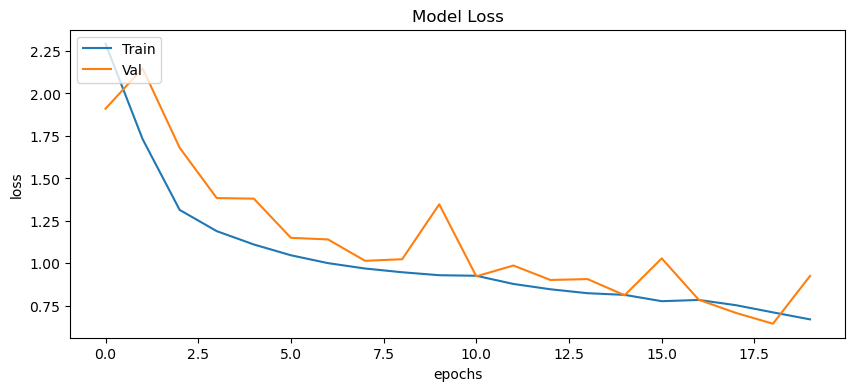

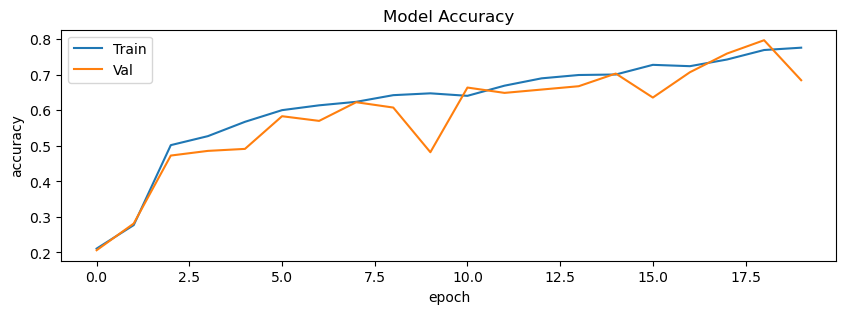

40/40 [==============================] - 13s 328ms/step - loss: 0.9742 - accuracy: 0.6747
[0.9741828441619873, 0.6746698617935181]
CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.2}
Epoch 1/20
34/34 [==============================] - 75s 2s/step - loss: 2.2707 - accuracy: 0.2138 - val_loss: 1.8222 - val_accuracy: 0.1707
Epoch 2/20
34/34 [==============================] - 74s 2s/step - loss: 1.6709 - accuracy: 0.3108 - val_loss: 1.5525 - val_accuracy: 0.3827
Epoch 3/20
34/34 [==============================] - 74s 2s/step - loss: 1.3591 - accuracy: 0.4346 - val_loss: 1.2306 - val_accuracy: 0.4803
Epoch 4/20
34/34 [==============================] - 74s 2s/step - loss: 1.2100 - accuracy: 0.4970 - val_loss: 1.1330 - val_accuracy: 0.5291
Epoch 5/20
34/34 [==============================] - 74s 2s/step - loss: 1.0954 - accuracy: 0.5504 - val_loss: 1.1253 - val_accuracy: 0.5197
Epoch 6/20
34/34 [==============================] - 74s 2s/step - loss: 1.0611 - accu

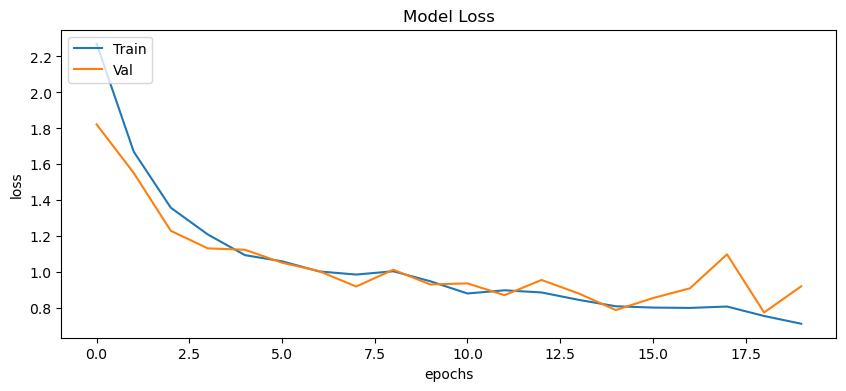

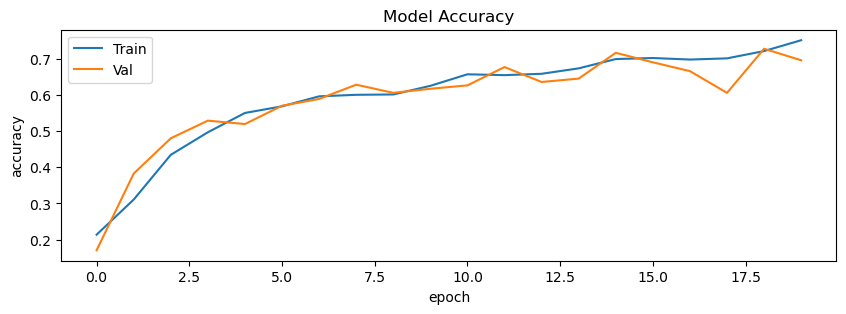

40/40 [==============================] - 13s 332ms/step - loss: 0.9308 - accuracy: 0.6955
[0.9308475255966187, 0.6954782009124756]
CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.3}
Epoch 1/20
34/34 [==============================] - 75s 2s/step - loss: 2.1366 - accuracy: 0.2799 - val_loss: 1.5875 - val_accuracy: 0.3490
Epoch 2/20
34/34 [==============================] - 231s 7s/step - loss: 1.3619 - accuracy: 0.4430 - val_loss: 1.6139 - val_accuracy: 0.3809
Epoch 3/20
34/34 [==============================] - 75s 2s/step - loss: 1.1995 - accuracy: 0.5143 - val_loss: 1.5967 - val_accuracy: 0.3790
Epoch 4/20
34/34 [==============================] - 75s 2s/step - loss: 1.1259 - accuracy: 0.5354 - val_loss: 1.4505 - val_accuracy: 0.4784
Epoch 5/20
34/34 [==============================] - 75s 2s/step - loss: 1.0625 - accuracy: 0.5757 - val_loss: 1.2277 - val_accuracy: 0.5178
Epoch 6/20
34/34 [==============================] - 75s 2s/step - loss: 1.0149 - acc

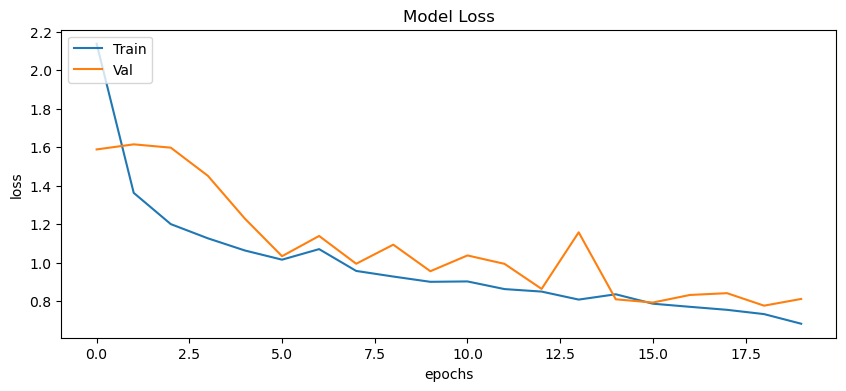

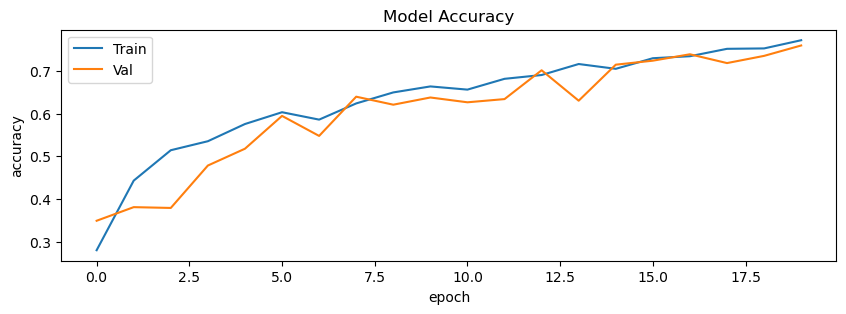

40/40 [==============================] - 13s 333ms/step - loss: 0.7619 - accuracy: 0.7563
[0.7618743181228638, 0.756302535533905]


In [7]:
import itertools
param_grid=dict(
    #
    # l2_param=[0.01, 0.001, 0.0001],
    last_dropout_param=[0.1, 0.2, 0.3],
    #batch_size_param=[16, 32, 128],
    #epochs_param=[10, 20, 30]
)

keys = list(param_grid.keys())
params = list(param_grid.get(x) for x in keys)
param_permutations = list(itertools.product(*params))

model_history = []

for perm in param_permutations:
    model_args = dict()
    for index in range(len(params)):
        key = keys[index]
        value = perm[index]
        model_args[key] = value
    print("CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:")
    print(model_args)
    model = create_model(**model_args)
    history = model.fit(train_ds, validation_data=val_ds, epochs=20)
    %run rueegg_wissiak_model_visualization.ipynb
    eval = model.evaluate(test_ds)
    print(eval)
    model_history.append(dict(history=history, model=model))

## Training the Model

In [8]:
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                 

In [9]:
#history = model.fit(train_ds, validation_data=val_ds, epochs=10)

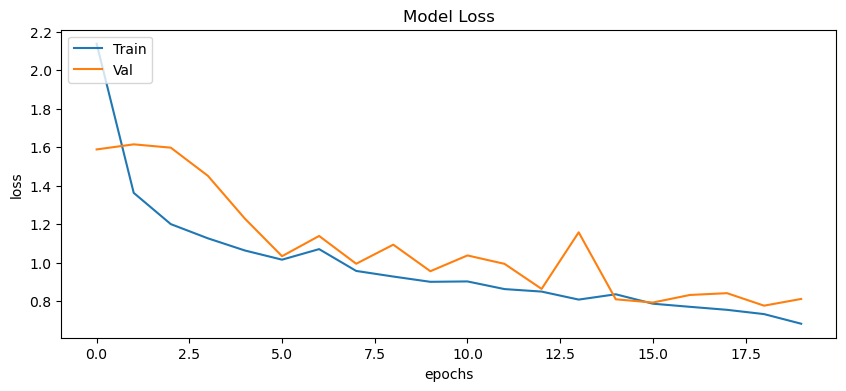

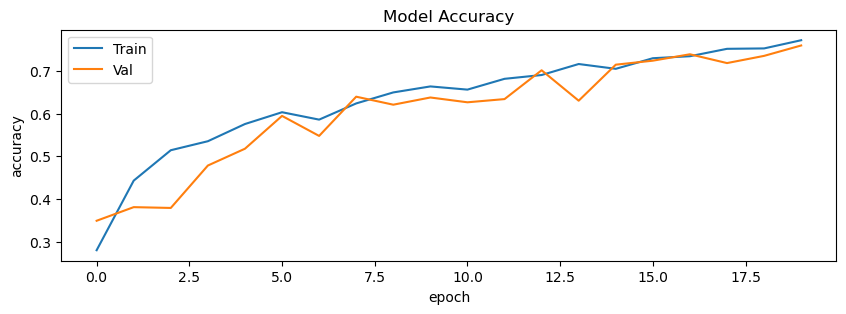

In [10]:
%run rueegg_wissiak_model_visualization.ipynb

In [11]:
model.evaluate(test_ds)

40/40 [==============================] - 14s 339ms/step - loss: 3.3154 - accuracy: 0.2993


[3.31538987159729, 0.29931971430778503]